In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [82]:
!nvidia-smi

Fri Nov 15 07:41:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              50W / 400W |    505MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [83]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [84]:
building_id = 32
subset_df = pd.read_csv('/content/drive/MyDrive/Team-Fermata-Energy/processed_data/subset20.csv')
processed_df = pd.read_csv(f'/content/drive/MyDrive/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp/{building_id}.csv')

In [85]:
processed_df.columns = [re.sub(r"[^A-Za-z0-9_]+", "_", col) for col in processed_df.columns]

In [86]:
processed_df.head(2)

,timestamp,out_electricity_total_energy_consumption,Dry_Bulb_Temperature_C_,Relative_Humidity_,heat_index,minute,hour,day,month,is_weekday,is_holiday,max_load_hourly,min_load_hourly,max_temp_hourly,min_temp_hourly,bldg_id
0,2018-01-01 01:00:00,5.420033,-6.10,42.781847,21.02,0,1,1,1,1,1,5.476113,5.420033,-6.1,-6.55,32
1,2018-01-01 01:15:00,5.476113,-6.25,43.350762,20.75,15,1,1,1,1,1,5.476113,5.420033,-6.1,-6.55,32


In [87]:
y = processed_df['out_electricity_total_energy_consumption']
X = processed_df.drop(columns=['out_electricity_total_energy_consumption', 'timestamp', 'bldg_id'])
# X = X.interpolate(method='linear')

In [88]:
# split the data into training and testing sets
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples")

Training on 5842 samples, Testing on 5839 samples
Training on 11681 samples, Testing on 5839 samples
Training on 17520 samples, Testing on 5839 samples
Training on 23359 samples, Testing on 5839 samples
Training on 29198 samples, Testing on 5839 samples


In [89]:
# random forest model
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(tree_method='hist',
                             device='cuda',
                             reg_alpha=1.0,
                             reg_lambda=1.0,
                             random_state=42)


In [90]:
# parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1,2,3,4,5],
    'learning_rate': [0.1, 0.2],
    'min_samples_split': [2],           # Minimum samples required to split an internal node
    #'min_samples_leaf': [1, 2, 4],             # Minimum samples required at a leaf node
    #'max_features': ['sqrt', 'log2', None]     # Number of features to consider at each split (valid values)
}


# grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=2, n_jobs=-1,
                           verbose=2, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


In [91]:
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

In [92]:
# performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error (MAE): 0.09749954851551039
Mean Squared Error (MSE): 0.07522208904284258
R-squared: 0.9906225409811976


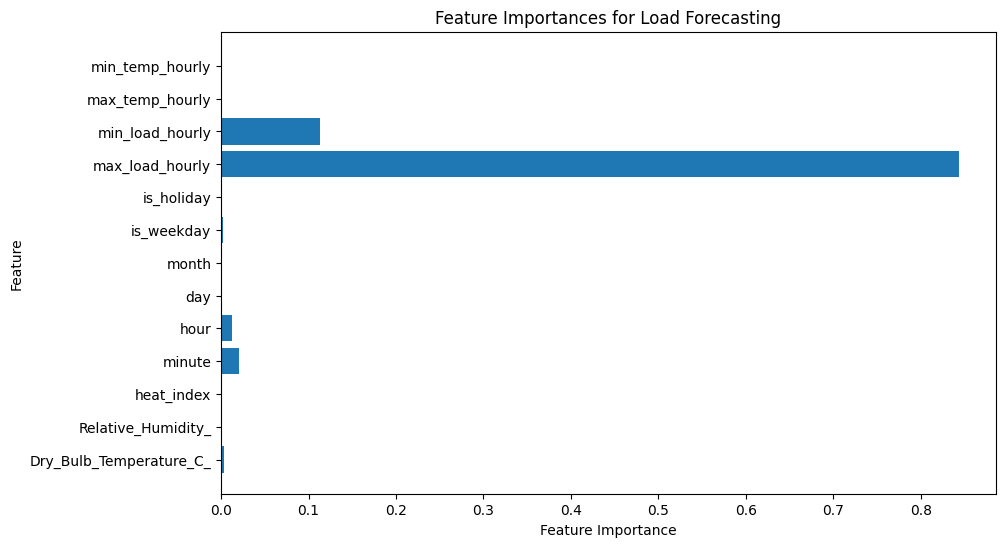

In [93]:
feature_importances = best_xgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Load Forecasting')
plt.show()